# **LSTM - Movie Sentiment Analysis** 

## **0. Settings**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#import all used library
import pandas as pd # read datasets

# libraries to load datasets and handle models 
import torch
import numpy as np 
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

# time management 
import os
import time
import datetime

# plotting 
import matplotlib.pyplot as pyplot

# math lib 
import math

## **1. Prepare Data for the Training Model**

### **1.1. Import and Classify Data**

The data in IMDB Review Dataset is structured into a .csv file that allows us to construct a pandas dataframe out of the data. The dataframe consists of five columns: *No, type, review, label, file*. The data is classified into two different types *train* and *test* to facilitate the training and testing processes. 

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/NLP2022/movie_sentiments/data/imdb_master.csv", encoding='unicode_escape')

In [ ]:
data.head()

,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [ ]:
data.tail()

,Unnamed: 0,type,review,label,file
99995,99995,train,"Delightfully awful! Made by David Giancola, a ...",unsup,9998_0.txt
99996,99996,train,"Watching Time Chasers, it obvious that it was ...",unsup,9999_0.txt
99997,99997,train,At the beginning we can see members of Troma t...,unsup,999_0.txt
99998,99998,train,"The movie was incredible, ever since I saw it ...",unsup,99_0.txt
99999,99999,train,"TCM came through by acquiring this wonderful, ...",unsup,9_0.txt


We are interested in the data with predefined labels *pos* and *neg*, and so we will extract only the data with these labels. 

In [ ]:
data = data[(data.label == "pos") | (data.label == "neg")]  # only use reviews with either a pos or a neg label

In [ ]:
#train_data = data[data["type"] == "train"]  # classify data by train and test types
#test_data = data[data["type"] == "test"]
#train = train_data.iloc[:,2:4]  # delete the first two columns and the last column, retaining columns 'review' and 'label'
#test = test_data.iloc[:,2:4]

Next, we want to delete redundant columns and only retain columns *'review'* and *'label'*. 

In [ ]:
data = data.iloc[:,2:4]  

In [ ]:
data.head()

,review,label
0,Once again Mr. Costner has dragged out a movie...,neg
1,This is an example of why the majority of acti...,neg
2,"First of all I hate those moronic rappers, who...",neg
3,Not even the Beatles could write songs everyon...,neg
4,Brass pictures (movies is not a fitting word f...,neg


### **1.2. Shuffle Data**

Since the dataset is currently arranged in an alphabetical order, it is important to shuffle the dataset so as to avoid any pattern that can affect the learning process. This is a basic rule in training deep learning model.

Particularly, if we divide the dataset into training set and validating set: about 1000 last words will be assigned into validating set. This could cause an unexpected scenario: the developed model could perform significantly bad on words beginning with 'y' or 'z' because it has never been trained to predict words like that.

In [ ]:
data = data.sample(frac = 1).reset_index(drop=True)

In [ ]:
data.head()

,review,label
0,Cast to die for in a movie that is considerabl...,neg
1,The production value of AvP2 can be described ...,neg
2,"When I learned of Sir Alec Guinness' death, th...",pos
3,Alexandra Ripley wrote a horrible sequel to Ma...,neg
4,A talented high school graduating senior with ...,pos


### **1.3. Standardize Data**

This step transforms words into lowercase ones and then removes punctuations and break signs from each review in the *review* column. 

In [ ]:
def standardizeData(input_column):
    punctuations = ['"', '!', '#', '$', '&', '\'' , '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '\\', '^', '_', '`', '{', '|', '}', '~' ]
    standardized_column = []
    for review in input_column: 
        review = review.lower()
        review = review.replace('<br />', ' ')
        for punc in punctuations: 
            review = review.replace(punc, ' ')
        standardized_column.append(review)
    return standardized_column

In [ ]:
data.review = standardizeData(data.review)

In [ ]:
data.head()

,review,label
0,cast to die for in a movie that is considerabl...,neg
1,the production value of avp2 can be described ...,neg
2,when i learned of sir alec guinness death th...,pos
3,alexandra ripley wrote a horrible sequel to ma...,neg
4,a talented high school graduating senior with ...,pos


## **2. Convert Words to Tensors**

### **2.1 Build a Dictionary of Words to Integers**

Firstly, we convert the data into a Python list. 

In [ ]:
list_of_reviews = list(data["review"])
list_of_labels = list(data["label"])

Next, we construct a list of words from all of the reviews and count the frequency of each word using Counter. Counter gives us a mapping of words that appear in the word list to their frequency in the corpus. 

In [ ]:
corpus = ' '.join(list_of_reviews)
words = corpus.split()

words_freq_dict = Counter(words)

The corpus is made up of user-written reviews that may contain typos, slangs, etc. Thus, we will focus on the 30,000 most common words in the word list. The Counter object offers the method *most_common(n)* that returns the *n* most popular words in the dictionary. 

In [ ]:
vocab_list = words_freq_dict.most_common(29999)
print(vocab_list[:10])
print(vocab_list[-10:])

[('the', 667989), ('and', 324427), ('a', 322969), ('of', 289405), ('to', 268119), ('is', 211082), ('it', 190735), ('in', 186778), ('i', 175534), ('this', 150997)]
[('eek', 8), ('rediscovery', 8), ('solidifies', 8), ('compulsively', 8), ('specs', 8), ('minutiae', 8), ('attal', 8), ('clearest', 8), ('somersaults', 8), ('foreheads', 8)]


The list of the last 10 words in the *vocab_list* (consisting of 30,000 most common words) shows that words in our vocabulary have to appear at least 8 times. This helps us avoid unfamiliar words or typos. 

Next, we construct a dictionary that maps each word in our vocab list to an integer. For any word that is not included in our vocab, we assign a 0 representing a *OOV (out of vocab)* word. 

In [ ]:
word_to_int = {word_freq_tuple[0]: id for id, word_freq_tuple in enumerate(vocab_list, 1)}
word_to_int['OOV'] = 0

### **2.2. Convert each review to a list of ints representing words** 

Now, as we have a dictionary of words to integers for our corpus, we want to construct a LoL of reviews, each inner list of which is a vector of integers representing words in each review. For any word that is not included in our vocab, we assign a 0 representing a OOV (out of vocab) word.

In [ ]:
wordID_vector_by_review = []

for review in list_of_reviews:
    wordID_vector = [word_to_int[word] if word in word_to_int else 0 for word in review.split()] # list of ints representing words in the review
                                                                                                 # id = 0 if word = OOV 
    wordID_vector_by_review.append(wordID_vector)

In [ ]:
print(wordID_vector_by_review[:2])

[[178, 5, 716, 16, 8, 3, 15, 11, 6, 5642, 341, 6620, 7751, 6, 1672, 18, 162, 54, 268, 54, 827, 5, 378, 42, 3067, 1, 63, 4, 42, 113, 2, 4, 42, 1003, 110, 10, 6, 28, 4, 146, 98, 61, 46, 1, 166, 2, 1410, 4, 109, 3, 80, 19, 332, 84, 32, 27, 36, 107, 80, 150, 2, 1507, 8, 7, 36, 7, 186, 5, 29, 44, 138, 77, 72, 1, 13953, 11, 7, 64, 6, 23, 74, 14, 139, 18, 17, 7751, 6250, 10316, 3587, 500, 4751, 3804, 18604, 5489, 9134, 5552, 10529, 13735, 2337, 2347, 4680, 8724, 2, 401, 30, 734, 487, 369, 20, 526, 52, 72, 3, 17699, 63, 1596, 3, 224, 52, 72, 3, 22962, 873, 850, 16, 1897], [1, 354, 1086, 4, 0, 50, 29, 2089, 33, 28, 16917, 374, 1, 226, 6, 642, 59, 8, 1, 2966, 1591, 4, 16578, 47, 25, 1, 0, 49, 16, 22, 1, 3361, 12, 1366, 134, 6, 1, 3361, 6139, 55, 30, 3832, 4, 26, 2389, 2, 72, 3150, 3441, 57, 17, 0, 2, 59, 5383, 1, 639, 4, 34, 9044, 394, 919, 134, 6, 1, 3361, 617, 134, 6, 1, 3361, 0, 316, 62, 22, 688, 18, 22, 26, 345, 1284, 134, 125, 1, 3361, 94, 26, 296, 36, 8262, 16, 316, 33, 3362, 177, 1, 2042,

As we can tell from the first two vectors, their sizes are not the same. What about the other review in the LoL? We can visualize this using a histogram as below: 

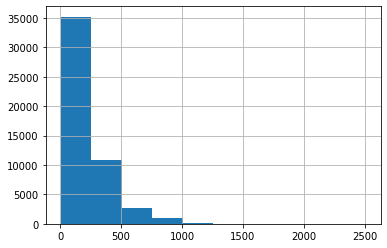

count    50000.000000
mean       235.562980
std        174.393214
min          6.000000
25%        129.000000
50%        177.000000
75%        286.000000
max       2505.000000
dtype: float64

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

review_len = [len(vector) for vector in wordID_vector_by_review]
pd.Series(review_len).hist()
plt.show()
pd.Series(review_len).describe()

Among 50,000 reviews in the dataset, the mean number of words is around 235, while the min is 6 words and the max is 2505 words in a review. The distribution of number of words in the reviews is greatly skewed right with only a small number of reviews having more than 500 words.  

### **2.3. Padding/Truncating Reviews** 

With such large variations in the number of words in each review, it is important to have all vectors in the same shape so as to utilize the properties of matrices. One solution for this problem is to pad or truncate the reviews. In this case, padding should be used.



In [ ]:
def pad_reviews(reviews, desired_vector_length):
    features = np.zeros((len(reviews), desired_vector_length), dtype=int)

    for id, review in enumerate(reviews):
        features[id, -len(review):] = np.array(review)[:desired_vector_length]
    return features

In [ ]:
features = pad_reviews(wordID_vector_by_review, 235)

In [ ]:
features.shape 

(50000, 235)

### **2.4. Partition Data into Training, Validation, and Test Set**

We select 9/10 of the corpus (45,000 reviews) to be training set, one half of the remaining (1/20 or 2,500 reviews) to be the validation set, and the remaining reviews (2,500 reviews) to be the test set. 


In [ ]:
split_frac = 0.9
last_training_index = int(len(features) * split_frac)

train_features, remaining_features = features[:last_training_index], features[last_training_index:]

labels_to_numbers = [1 if label == "pos" else 0 for label in list_of_labels]
labels = np.array(labels_to_numbers)
train_labels, remaining_labels = labels[:last_training_index], labels[last_training_index:]

In [ ]:
validation_test_frac = 0.5
last_validation_index = int(len(remaining_features) * validation_test_frac)

val_features, test_features = remaining_features[:last_validation_index], remaining_features[last_validation_index:]
val_labels, test_labels = remaining_labels[:last_validation_index], remaining_labels[last_validation_index:]

In [ ]:
## print out the shapes of your resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_features.shape), 
      "\nValidation set: \t{}".format(val_features.shape),
      "\nTest set: \t\t{}".format(test_features.shape))

			Feature Shapes:
Train set: 		(45000, 235) 
Validation set: 	(2500, 235) 
Test set: 		(2500, 235)


### **2.5. Construct Tensor Datasets**

In [ ]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_features), torch.from_numpy(train_labels))
valid_data = TensorDataset(torch.from_numpy(val_features), torch.from_numpy(val_labels))
test_data = TensorDataset(torch.from_numpy(test_features), torch.from_numpy(test_labels))

In [ ]:
# dataloaders
batch_size = 50

# make sure the SHUFFLE your training data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)

## **3. Build Model** 

### **3.0. Check if GPU is Available**

In [ ]:
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

No GPU available, training on CPU.


### **3.1. Construct a LSTM Class**

In [ ]:
class LSTM(nn.Module):


    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers):
        """
        Initialize the model by setting up the layers.
        """
        super(LSTM, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True)

        # dropout layers
        self.dropout = nn.Dropout(0.2)

        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, 256)
        self.sig = nn.Sigmoid()


    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.dropout(lstm_out)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

### **3.2. Initialize the Model** 

In [ ]:
vocab_size = len(word_to_int) + 1 # +1 for the 0 padding + our word tokens
output_size = 1
embedding_dim = 100
hidden_dim = 256
n_layers = 2

sentiment_LSTM = LSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print('LSTM \n', sentiment_LSTM)

LSTM 
 LSTM(
  (embedding): Embedding(30001, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=256, out_features=256, bias=True)
  (sig): Sigmoid()
)


In [ ]:
# loss and optimization functions
learning_rate = 0.0005

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(sentiment_LSTM.parameters(), lr=learning_rate)

## **4. Train Model** 

In [ ]:
#functions used for training models
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

def save_model(filename, decoder):
    save_filename = os.path.splitext(os.path.basename(filename))[0] + '.pt'
    torch.save(decoder, save_filename)

def load_model(filename):
    save_filename = os.path.splitext(os.path.basename(filename))[0] + '.pt'
    return torch.load(save_filename)

In [ ]:
# training params

epochs = 1 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 100
clip = 5 # gradient clipping

In [ ]:
#lists used for plotting losses
step_list = list()
train_loss_list = list()
val_loss_list = list()

In [ ]:
#use min_loss to track the best model throughout the training loop
min_val_loss = math.inf

In [ ]:
# move model to GPU, if available
if(train_on_gpu):
   sentiment_LSTM.cuda()

In [ ]:
train_on_gpu

False

In [ ]:
sentiment_LSTM.train()

# train for some number of epochs
for e in range(epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(e + 1, epochs))
    print('Training...')

    t0 = time.time()

    # initialize hidden state
    h = sentiment_LSTM.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        sentiment_LSTM.zero_grad()

        # get the output from the model
        inputs = inputs.type(torch.LongTensor)
        output, h = sentiment_LSTM(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(sentiment_LSTM.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = sentiment_LSTM.init_hidden(batch_size)
            val_losses = []
            sentiment_LSTM.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                inputs = inputs.type(torch.LongTensor)
                output, val_h = sentiment_LSTM(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            sentiment_LSTM.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))


======== Epoch 1 / 1 ========
Training...


KeyboardInterrupt: ignored